# Table of Contents
0. Python/SQL setup
1. Database Exploration and Querying
2. Visualization
3. Exporting Dataframes

### 0. Python/SQL Setup

In [15]:
# 0.0 -- Importing packages
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import regex as re
import os
from pathlib import Path

In [16]:
# 0.1 -- Checking pyodbc drivers
for driver in pyodbc.drivers():
    print(driver)

SQL Server
PostgreSQL ANSI(x64)
PostgreSQL Unicode(x64)
MySQL ODBC 8.0 ANSI Driver
MySQL ODBC 8.0 Unicode Driver
SQL Server Native Client 11.0
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server


In [17]:
# 0.2 -- Defining our server name and database name
# And establishing a connection to the database
SERVERNAME = os.environ.get('SQL_EXPRESS_SERVER')
server = SERVERNAME + "\SQLEXPRESS"
database = "AdventureWorks2019"
cnxn = pyodbc.connect(f"""
DRIVER={{ODBC Driver 17 for SQL SERVER}};
SERVER={server};
DATABASE={database};
Trusted_Connection=yes;
MARS_CONNECTION=yes;
""")

In [18]:
# 0.3 -- Creating the connection cursor
cursor = cnxn.cursor()

### 1. Database Exploration and Querying

Logic of table joins used in the following query:

| Table | Alias |Reason | Key |
| :--------- | :--------- | :--------- | :--------- |
| 1. Sales.SalesOrderHeader | header |Location/sales data | CustomerID, SalesOrderID, ShipToAddressID
| 2. Person.Address | address | Location data at a more granular level | AddressID, StateProvinceID
| 3. Person.StateProvince | state |State data | StateProvinceID, CountryRegionCode
| 4. Person.CountryRegion | country |Country data | CountryRegionCode  
| 5. Sales.vPersonDemographics | demo | Demographic data per customer | BusinessEntityID
| 6. Person.BusinessEntityAddress | ent | PK BusinessEntityID | AddressID, BusinessEntityID
| 7. Sales.SalesOrderDetail | detail | Numerical sales data | ProductID, SalesOrderID
| 8. Production.Product | prod | Categorical/dimensional data regarding products | ProductID, ProductSubcategoryID
| 9. Production.ProductSubcategory | subcat | Subcategory of products | ProductSubcategoryID, ProductCategoryID
| 10. Production.ProductCategory| cat | Category of products | ProductCategoryID


In [19]:
# 1.0 -- Querying database for demographic data from customers in North America
query = """SELECT 
                demo.BusinessEntityID, 
                state.Name, 
                address.StateProvinceID, 
                state.StateProvinceCode, 
                CAST(BirthDate AS date) AS BirthDate, 
                MaritalStatus, 
                YearlyIncome, 
                Gender, 
                TotalChildren, 
                NumberCarsOwned, 
                Education, 
                Occupation, 
                City, 
                state.StateProvinceCode AS StateCode, 
                state.Name AS State, 
                state.CountryRegionCode, 
                country.Name AS Country, 
                address.PostalCode, 
                cat.Name AS Category, 
                subcat.Name AS Subcategory,  
                SUM(detail.OrderQty) AS OrderQty, 
                SUM(header.TotalDue) AS TotalDue 
        FROM Sales.SalesOrderHeader header 
        JOIN Person.Address address 
                ON address.AddressID = header.ShipToAddressID 
        JOIN Person.StateProvince state 
                ON state.StateProvinceID = address.StateProvinceID 
        JOIN Person.CountryRegion country 
                ON country.CountryRegionCode = state.CountryRegionCode 
        JOIN Sales.vPersonDemographics demo 
                ON demo.BusinessEntityID = header.CustomerID 
        JOIN Person.BusinessEntityAddress ent
                ON ent.BusinessEntityID = demo.BusinessEntityID 
        JOIN Sales.SalesOrderDetail detail
                ON detail.SalesOrderID = header.SalesOrderID 
        JOIN Production.Product prod
                ON prod.ProductID = detail.ProductID 
        JOIN Production.ProductSubcategory subcat
                ON subcat.ProductSubcategoryID = prod.ProductSubcategoryID 
        JOIN Production.ProductCategory cat
                ON cat.ProductCategoryID = subcat.ProductCategoryID 
        GROUP BY 
                demo.BusinessEntityID, 
                state.Name, 
                address.StateProvinceID, 
                state.StateProvinceCode, 
                CAST(BirthDate AS date), 
                MaritalStatus, 
                YearlyIncome, 
                Gender, 
                TotalChildren, 
                NumberCarsOwned, 
                Education, 
                Occupation, 
                City, 
                state.StateProvinceCode, 
                state.Name, 
                state.CountryRegionCode, 
                country.Name, 
                address.PostalCode, 
                cat.Name, 
                subcat.Name 
        ORDER BY state.Name"""
custdf = pd.read_sql(query, cnxn) 
print(custdf.shape)
display(custdf.head())

(27556, 22)


,BusinessEntityID,Name,StateProvinceID,StateProvinceCode,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberCarsOwned,...,City,StateCode,State,CountryRegionCode,Country,PostalCode,Category,Subcategory,OrderQty,TotalDue
0,11533,Alabama,3,AL,1974-04-21,S,25001-50000,F,0,1,...,Birmingham,AL,Alabama,US,United States,35203,Accessories,Tires and Tubes,2,41.21
1,15175,Alberta,1,AB,1969-08-16,M,75001-100000,F,1,0,...,Calgary,AB,Alberta,CA,Canada,T2P 2G8,Accessories,Bike Racks,1,2725.22
2,15175,Alberta,1,AB,1969-08-16,M,75001-100000,F,1,0,...,Calgary,AB,Alberta,CA,Canada,T2P 2G8,Accessories,Tires and Tubes,3,8175.65
3,15175,Alberta,1,AB,1969-08-16,M,75001-100000,F,1,0,...,Calgary,AB,Alberta,CA,Canada,T2P 2G8,Bikes,Mountain Bikes,1,2725.22
4,15175,Alberta,1,AB,1969-08-16,M,75001-100000,F,1,0,...,Calgary,AB,Alberta,CA,Canada,T2P 2G8,Bikes,Touring Bikes,1,2634.40


In [20]:
# 1.1 -- Checking the status of our NaNs in custdf
# NaNs in our demographic data is just fine
# We're more interested in our TotalDue column, which has 0 NaNs
def nanpct(x) :
    print(x.shape)
    dfnan = x.isna().sum()
    dfnanpct = round(x.isna().sum() / len(x) * 100, 1)     
    display(pd.DataFrame(pd.concat((dfnan, dfnanpct), axis = 1).rename(columns= {0: 'NaNs', 1: '%total'})))
nanpct(custdf)

(27556, 22)


,NaNs,%total
BusinessEntityID,0,0.00
Name,0,0.00
StateProvinceID,0,0.00
StateProvinceCode,0,0.00
BirthDate,0,0.00
MaritalStatus,0,0.00
YearlyIncome,0,0.00
Gender,0,0.00
TotalChildren,0,0.00
NumberCarsOwned,0,0.00


In [21]:
# 1.2 Next, we'll create an Age column by subtracting BirthDate from today's date
# BirthDate will first need to be converted to datetime
custdf['BirthDate'] = pd.to_datetime(custdf['BirthDate'])

In [22]:
# 1.3 -- Now, we're writing a function and applying lambda to create our new Age column
# We'll subtract 5yrs from Age to account for an approximate difference in the present year and the year of recording
# Age will display values of customer ages closer to date of purchase
def calculate_age(x):
    today = date.today()
    return today.year - x.year - ((today.month, today.day) < (x.month, x.day))
custdf['Age'] = custdf.BirthDate.apply(lambda x: calculate_age(x) - 5)

In [23]:
# 1.4 -- Dropping BirthDate and reordering columns
custdf.drop(columns= 'BirthDate', inplace= True)
custdf = custdf [['BusinessEntityID', 'StateProvinceID', 'StateProvinceCode', 'Age',
       'MaritalStatus', 'YearlyIncome', 'Gender', 'TotalChildren',
       'NumberCarsOwned', 'Education', 'Occupation', 'City', 'StateCode',
       'State', 'CountryRegionCode', 'Country', 'PostalCode', 'Category', 'Subcategory', 'OrderQty',
       'TotalDue']]

In [24]:
# 1.6 -- Checkpoint: all set with custdf
custdf.sample(5)

,BusinessEntityID,StateProvinceID,StateProvinceCode,Age,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberCarsOwned,Education,...,City,StateCode,State,CountryRegionCode,Country,PostalCode,Category,Subcategory,OrderQty,TotalDue
21828,15666,163,77,62,M,75001-100000,M,3,3,High School,...,Lieusaint,77,Seine et Marne,FR,France,77127,Clothing,Jerseys,1,713.77
14725,11457,50,NSW,39,S,0-25000,F,0,0,Partial College,...,Wollongong,NSW,New South Wales,AU,Australia,2500,Bikes,Mountain Bikes,2,6337.12
13860,14148,19,HE,64,M,25001-50000,F,3,2,High School,...,Kassel,HE,Hessen,DE,Germany,34117,Bikes,Mountain Bikes,1,915.46
7860,18064,9,CA,47,M,75001-100000,M,2,0,Graduate Degree,...,Lakewood,CA,California,US,United States,90712,Clothing,Jerseys,1,65.17
23430,13961,77,VIC,49,S,50001-75000,M,0,1,Graduate Degree,...,Sunbury,VIC,Victoria,AU,Australia,3429,Accessories,Tires and Tubes,2,192.16


### 2. Visualization

In [25]:
# 2.0 -- Next, plotting a simple Seaborn barplot to double check future Tableau work
# This cell makes a list of the top 10 states by sum of TotalDue and assigns it to a new dataframe called 'top10states'
# We're also changing the pandas settings to display floats instead of scientific notation
top10states = pd.DataFrame(custdf.groupby('State')['TotalDue'].sum().sort_values(ascending=False).head(10))
pd.options.display.float_format = '{:.2f}'.format
display(top10states)

,TotalDue
State,
California,8336696.26
England,5817714.89
New South Wales,5586680.28
Washington,3686136.77
Victoria,3396883.75
British Columbia,2835729.20
Queensland,2768009.30
Oregon,1737159.26
Saarland,1300119.20


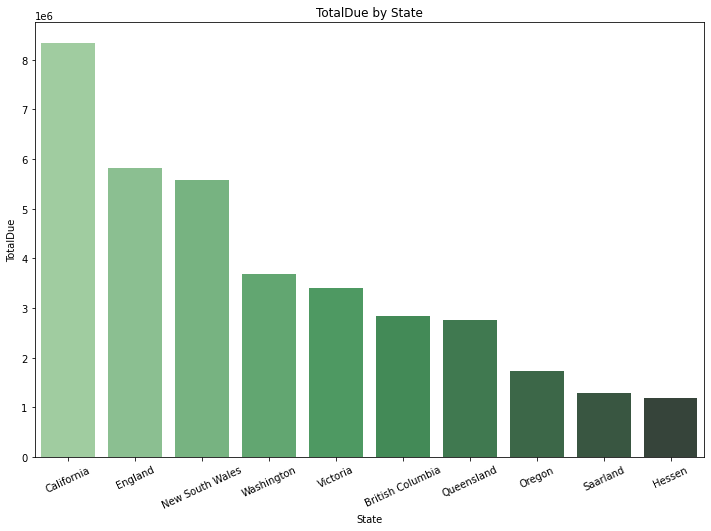

In [26]:
# 2.1 -- Here's our barplot
plt.figure(figsize=(12,8))
ax = sns.barplot(
    data = top10states, 
    x = top10states.index, 
    y = 'TotalDue',
    palette= 'Greens_d'
    ).set_title('TotalDue by State')
plt.xticks(rotation=25);

### 3. Exporting Dataframes

In [27]:
# 3.0 -- Our dataframe is now ready for export
custdf.to_csv(Path('Tableau Inputs') / 'AdventureWorks_Custdf.csv')